In [4]:
import numpy as np
import pylab as pl
%pylabn inline

from matplotlib.pyplot import figure, legend, show
from numpy import append, arange, atleast_1d, ceil, conj, diag, dot, exp, \
    flipud, fmod, histogram, int32, log2, mean, ones, pi, prod, real, trapz, tile
from numpy.linalg import cholesky
from numpy.random import randn
from scipy import convolve
from scipy.fftpack import fft, fftshift, ifft



UsageError: Line magic function `%pylabn` not found.


# generating noise
copied with minimal modifications from 

https://github.com/rilma/SignalProcessing

In [78]:

class Noise:

    def __init__(self, mu=0., n=1000, ntype='white', sigma=1.):

        """ Constructor
        
            Generates a sequence of random noise
            Based on "https://en.wikipedia.org/wiki/Colors_of_noise"
            INPUTS:
                mu      : Mean value of samples
                n       : No. of samples
                ntype   : noise type, see dictionary
                sigma   : Standard deviation of samples
        """
        ntypedict = { "white":1,
                      "pink":2,
                      "brown":3,
                      "blue":4,
                      "purple":5}
        self.mu = mu
        self.n = n
        self.ntype = ntypedict[ntype]
        self.sigma = sigma        
        if self.ntype == 1: self.white_noise()
        elif self.ntype in [2, 3, 4, 5]: self.color_noise()


    def white_noise(self):

        """ White Gaussian Noise (WGN)
            It generates random samples
        """

        self.x = self.mu + self.sigma * randn(self.n)
        self.label = 'White'


    def color_noise(self):

        """ It generates a sequence of 'colored" noise samples
        """

        N_dummy = atleast_1d(int(self.n))
        Nshp = N_dummy.shape

        if ((len(Nshp) > 1) | ((len(Nshp) == 1) & (len(N_dummy) > 1))):

            nSamples = prod(Nshp)
            x = self.n.reshape(nSamples)
            N = len(x)

            # ensuring that M is even
            M = N + 1 if fmod(N, 2) == 1 else N

        else:

            #
            # N - number of samples
            #

            # ensuring that M is even
            M = self.n + 1 if fmod(self.n, 2) == 1 else self.n

            x = self.mu + self.sigma * randn(M)  # Generates a random signal
        
        xX = fft(x)

        # multiplication vector for :
        #   1/f   -> Pink
        #   1/f^2 -> Red
        #   f     -> Blue
        #   f^2   -> Violet
        numUniquePts = int(M / 2) + 1
        n = arange(1, numUniquePts + 1)**.5 if self.ntype in [2, 4] \
            else arange(1, numUniquePts + 1) 

        # multiplicating the left half of the spectrum so the power spectral density
        # is inversely proportional to the frequency (1/f, 1/f^2, f, f^2), i.e. the amplitudes are 
        # inversely proportional to 1/sqrt(f), 1/f, sqrt(f), f
        xX[0 : numUniquePts] = xX[0 : numUniquePts] / n if self.ntype in [2, 3] \
            else xX[0 : numUniquePts] * n

        # prepare a right half of the spectrum - a copy of the left one,
        # except the DC component and Nyquist frequency - they are unique
        xX[numUniquePts : M] = conj(xX[int32(arange(M/2, 2 - 1, -1))])

        # IFFT
        y = ifft(xX)

        self.x = real(y) / max(abs(real(y)))        # Normalized

        self.label = ['Pink', 'Red', 'Blue', 'Violet'][self.ntype - 2] 


    def proc_noise(self, nhistb=100):

        """
                nhistb : No. of bins in histogram
        """

        self.nhistb = nhistb

        # Histogram
        self.hist, self.bin_edges = histogram(self.x, bins=self.nhistb, density=False)
        #
        # Normalized histogram
        self.norm_hist = append(self.hist, 0) / trapz(append(self.hist, 0), self.bin_edges)
        
        # Gaussian distribution (theoretical)
        self.t_gauss_df = exp(-(self.bin_edges - self.mu)**2/(2 * self.sigma**2)) / \
            (self.sigma * (2. * pi)**.5)

        # Autocorrelation
        self.Rxx = convolve(flipud(self.x), self.x) / self.n
        self.lags = arange(-self.n+1, self.n, 1)

        # Power Spectral Density (PSD)
        #
        self.N = int(2**ceil(log2(self.n)))   # Sample length set as a power of 2 (for FFT)        
        #
        # Generating WGN 
        #
        mu = self.mu * ones(self.N)                  # Mean for all realizations
        Cxx = self.sigma**2 * diag(ones(self.N))     # Covariance matrix for the random process
        R = cholesky(Cxx)                           # Cholesky of covariance matrix

        # Multivariate Gaussian distribution with a given mean and
        # Covariance matrix
        #
        if self.ntype == 1: sndterm = dot(randn(self.n, self.N), R)
        elif self.ntype in [2, 3, 4, 5]:
            Obj = Noise(n=int(self.n*self.N), ntype="pink")
            sndterm = dot(Obj.x.reshape((self.n, self.N)), R)
            
        z1 = sndterm + tile(mu, (self.n, 1))
        z2 = fft(z1) / self.N**.5

        # Mean power from FFT
        self.mean_power = fftshift(mean(z2 * conj(z2), axis=0))

        # Normalized freq.
        self.norm_freq = arange(-self.N/2, self.N/2) / float(self.N) 


    def plot_noise(self):

        f = figure(figsize=(16,6))

        pn1 = f.add_subplot(121)
        pn1.plot(range(self.n), self.x, label=self.label)
        pn1.set_title(r'$\mu$ = %8.3f, $\sigma$ = %8.3f' % (self.mu, self.sigma**2))
        pn1.set_xlabel('Sample')
        pn1.set_ylabel('Value')
        legend(loc='best')


       
        pn2 = f.add_subplot(122)
        pl.psd(self.x);
        #pn2.semilogy(self.norm_freq, self.mean_power)
        pn2.set_title('Power Spectral Density (%s Noise)' % self.label)
        pn2.set_xlabel('Normalized Freq.')
        pn2.set_ylabel('PSD (dB?/Hz)')




white


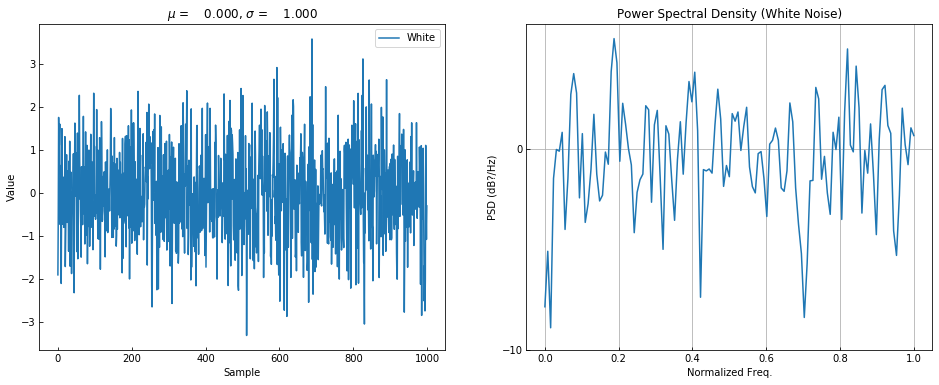

In [79]:
print("white")
Obj = Noise(ntype="white", n=1000)
Obj.proc_noise()
Obj.plot_noise()




pink


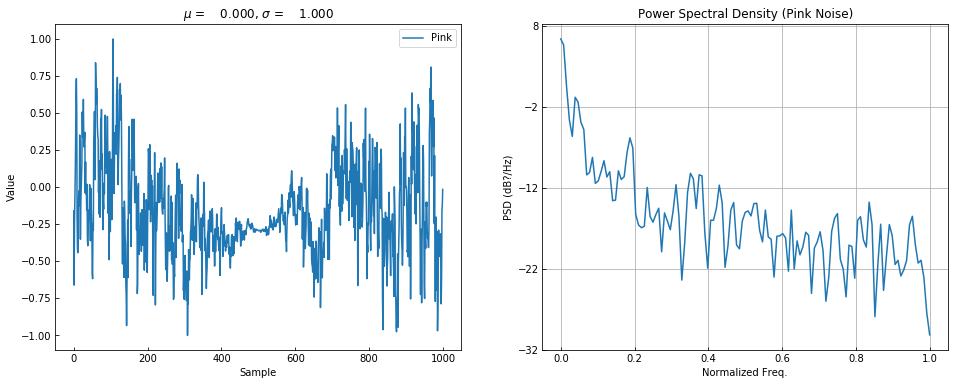

In [80]:
print("pink")
Obj = Noise(ntype="pink", n=1000)
Obj.proc_noise()
Obj.plot_noise()




brown


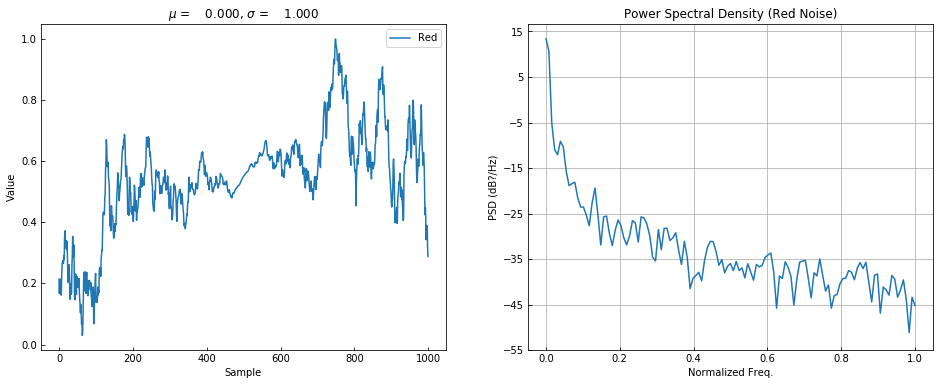

In [81]:
print("brown")
Obj = Noise(ntype="brown", n=1000)
Obj.proc_noise()
Obj.plot_noise()


blue


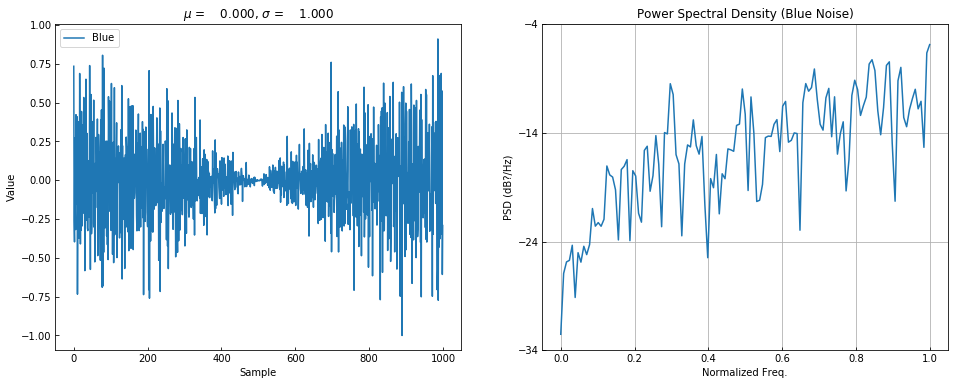

In [82]:
print("blue")
Obj = Noise(ntype="blue", n=1000)
Obj.proc_noise()
Obj.plot_noise()


purple


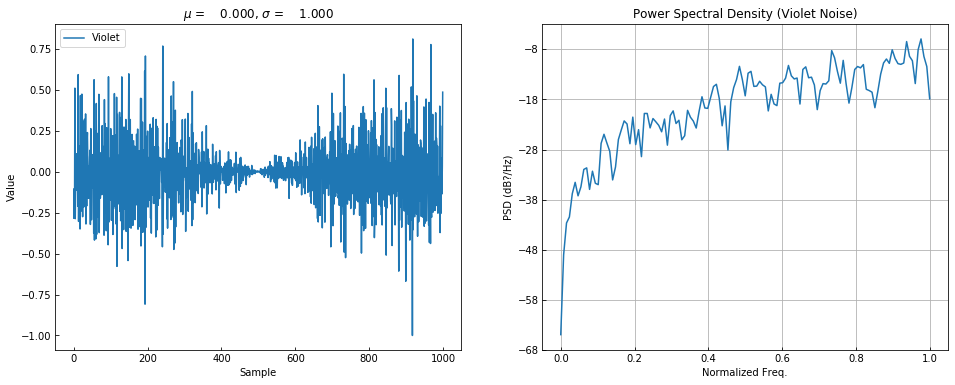

In [83]:
print("purple")
Obj = Noise(ntype="purple", n=1000)
Obj.proc_noise()
Obj.plot_noise()
